# Additional comparisons of female walking speed var explained vs neural models

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from disp import set_plot


STRAIN_KEY = '_'.join(['NM91', 'ZH23']).lower()
REG_KEY = 'ridge_alpha_10'

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

MASKED = True

## Behavioral predictions from song features

In [2]:
FHEUR = f'data/simple/mlv/heuristic/heuristics_single_{STRAIN_KEY}_mtn_masked.npy'
data = np.load(FHEUR, allow_pickle=True)[0]

SONG_HEURS = [
    'N_S_ONSETS',
    'N_P_ONSETS',
    'N_B_ONSETS',
    'S_TOTAL',
    'P_TOTAL',
    'B_TOTAL',
    # duration/ratio vars are undefined at many timepoints, which significantly changes the dataset used for fitting
    'MN_S_DUR',
    'MN_P_DUR',  
    'MN_B_DUR',
#     'SP_RATIO',
]
# WDWS_HEUR = [1, 10, 30, 60, 120, 240, 480, 1800]
WDWS_HEUR = [1, 10, 30, 60, 120, 240, 480]

LABELS = [
    '# sine\nonsets',
    '# pulse\nonsets',
    '# bout\nonsets',
    
    'Total sine',
    'Total pulse',
    'Total song',
    
    'Mean sine\nduration',
    'Mean pulse\nduration',
    'Mean bout\nduration',
]

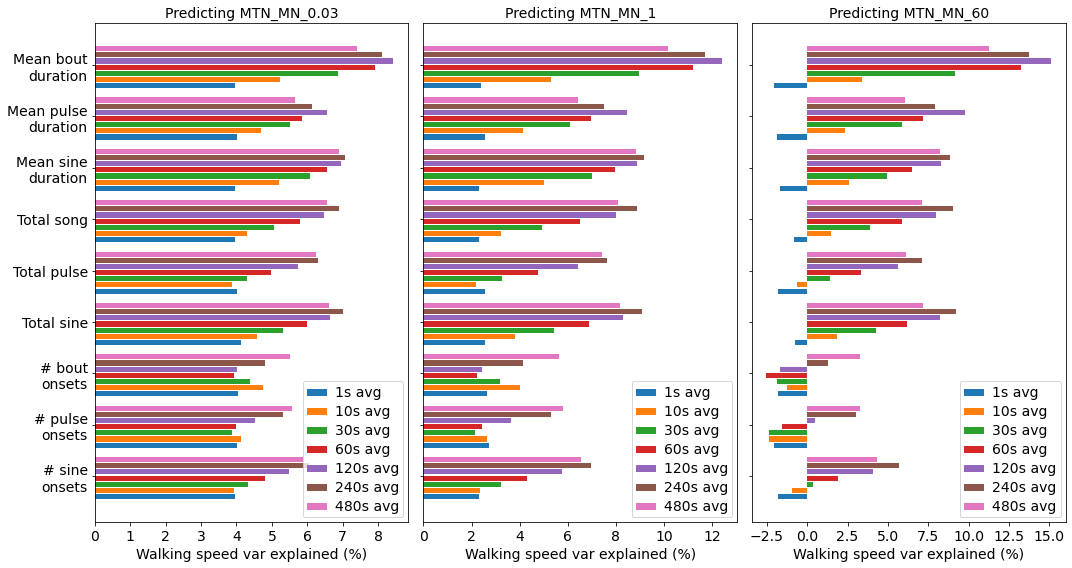

In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(1, 3, figsize=(15, 8), tight_layout=True, sharey=True)

r2_heurs_all = {targ: [] for targ in TARGS}

for targ, ax in zip(TARGS, axs):
    r2_test_mn = data['r2_test'][targ].mean(axis=0)
    r2_test_std = data['r2_test'][targ].std(axis=0)
    r2_test_sem = r2_test_std / np.sqrt(data['r2_test'][targ].shape[0])
    
    y_ticks = []
    
    for cfeat, feat in enumerate(SONG_HEURS):
        for cwdw, (wdw, color) in enumerate(zip(WDWS_HEUR, colors)):
            
            icol = data['heurs'].index(f'{feat}_{wdw}')
            ax.barh(cfeat + .12*cwdw, 100*r2_test_mn[icol], height=.1, color=color)
            
            r2_heurs_all[targ].append(data['r2_test'][targ][:, icol])
        
        y_ticks.append(cfeat+ .4)
        
        
    ax.legend([f'{wdw}s avg' for wdw in WDWS_HEUR])
    
    set_plot(ax, y_ticks=y_ticks, y_tick_labels=LABELS, x_label=r'Walking speed var explained (%)', title=f'Predicting {targ}', font_size=14)
    
# fig.savefig('supp/15_fmtn_from_song_feats.svg')

In [4]:
r2_heur_imaxs = {targ: np.argmax(np.array(r2_heurs_all[targ]).mean(axis=1)) for targ in TARGS}
r2_heur_maxs = {targ: np.array(r2_heurs_all[targ]).T[:, r2_heur_imax] for targ, r2_heur_imax in r2_heur_imaxs.items()}

## LN variations (including NA-matched LN model except without adjusting timescales to account for OFF responses)

In [5]:
NNRN = 224
NRL_MDLS = [
#     'linma',  # linear neural model w MA-derived filters
    
#     'lnr',  # linear-nonlinear model (fit w ridge regr)
#     'lnr_relu',  
#     'lnr_relu_flex',
    'lnma',  # lin-nonlin neural model w MA-derived filters
    'lnma_tweaked',  # lin-nonlin neural model w double-exp filter optimized from MA fit
    'lnma_tweaked_4',  # lin-nonlin neural model w double-exp filter optimized from MA fit (4 params only)
    
    'ma',  # mult-adapt neural model
    
    
#     'linr',  # linear neural model (fit w ridge regr)
    
#     'ma_ind_ta',
    
#     'lin',  # linear neural model
#     'ln',  # linear-nonlinear model
]

LABELS = {
    'ma': 'MA',
    'lnma': 'LN',
#     'lnr': 'LN-R',
#     'lnr_relu': 'LN-RELU',
#     'lnr_relu_flex': 'LN_FLEX',
    'lnma_tweaked': 'LNMA_TW',
    'lnma_tweaked_4': 'LNMA_TW_4',
    
    'linma': 'Lin',
    
#     'ma_ind_ta': 'MA_IND_TA',
    
    'MTN': 'Motion',
}

In [6]:
if not MASKED:
    # heuristic predictors
    time_rslt = np.load(f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]

    # linear fits
    lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]

#     # single-neuorn fits
#     single_rslts = [
#         np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]
#         for nrl_mdl in NRL_MDLS
#     ]

    # ppln fits
    ppln_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # shuffled MA fit
    shfl_rslt = np.load(f'data/simple/mlv/ma_shfl/baker_ma_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]
    
else:
    # heuristic predictors
    time_rslt = np.load(f'data/simple/mlv/heuristic/time_{STRAIN_KEY}_{TARG_BHV.lower()}_masked.npy', allow_pickle=True)[0]

    # linear fits
    lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]

#     # single-neuorn fits
#     single_rslts = [
#         np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}_masked.npy', allow_pickle=True)[0]
#         for nrl_mdl in NRL_MDLS
#     ]

    # ppln fits
    ppln_rslts = [
        np.load(f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    # shuffled MA fit
    shfl_rslt = np.load(f'data/simple/mlv/ma_shfl/baker_ma_{STRAIN_KEY}_{TARG_BHV.lower()}_{REG_KEY}_masked.npy', allow_pickle=True)[0]

TWDW 0.03
LNMA_TW vs MA: Ttest_indResult(statistic=-4.061615331190956, pvalue=0.00014810899801545092)
LNMA vs MA: Ttest_indResult(statistic=-2.440292033390983, pvalue=0.017751651948639615)
LNMA_TW_4 vs MA: Ttest_indResult(statistic=-3.762715329273104, pvalue=0.000393806472747351)
LNMA_TW vs LNMA: Ttest_indResult(statistic=-1.4412234005549664, pvalue=0.15489900531283027)
LNMA_TW_4 vs LNMA_TW: Ttest_indResult(statistic=0.135168454867934, pvalue=0.8929466968029548)

TWDW 1
LNMA_TW vs MA: Ttest_indResult(statistic=-4.692789612420238, pvalue=1.6883117723298314e-05)
LNMA vs MA: Ttest_indResult(statistic=-4.131549104641627, pvalue=0.0001172234593673505)
LNMA_TW_4 vs MA: Ttest_indResult(statistic=-6.2821292618178015, pvalue=4.649220677834158e-08)
LNMA_TW vs LNMA: Ttest_indResult(statistic=-0.4252262341419381, pvalue=0.6722453272229872)
LNMA_TW_4 vs LNMA_TW: Ttest_indResult(statistic=-1.440335761446517, pvalue=0.15514891528104874)

TWDW 60
LNMA_TW vs MA: Ttest_indResult(statistic=-5.22072844379

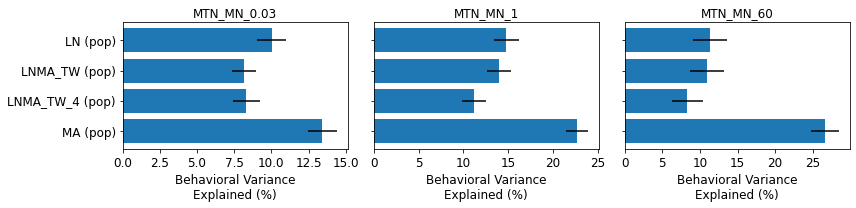

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
                
ma_ppln_r2s = {}

for ax, twdw in zip(axs, TWDWS):
    print('TWDW', twdw)
    labels = []
    r2_mns = []
    r2_sems = []
    
    targ = f'{TARG_BHV}_MN_{twdw}'
    
    r2_tests = {}
    
    # ppln results
    for nrl_mdl, ppln_rslt in zip(NRL_MDLS, ppln_rslts):
        labels.append(f'{LABELS[nrl_mdl]} (pop)')
        r2_mns.append(ppln_rslt['r2_test'][targ].mean())
        r2_sems.append(ppln_rslt['r2_test'][targ].std() / np.sqrt(ppln_rslt['nsplit']))
        
        if nrl_mdl == 'ma':
            ma_ppln_r2s[targ] = ppln_rslt['r2_test'][targ].mean()
            
        r2_tests[nrl_mdl] = ppln_rslt['r2_test'][targ]
        
    r2_mns = np.array(r2_mns)
    r2_sems = np.array(r2_sems)
    
    ax.barh(np.arange(len(r2_mns)), 100*r2_mns, xerr=100*r2_sems)
    ax.set_xlim(left=0)
    
    ax.set_yticks(np.arange(len(labels)))
    ax.set_ylim(len(r2_mns)-.4, -.6)
    if ax is axs[0]:
        ax.set_yticklabels(labels)
    else:
        ax.set_yticklabels([])
        
    set_plot(ax, x_label='Behavioral Variance\nExplained (%)', title=targ, font_size=12)
    
    # compute stats
    print('LNMA_TW vs MA:', stats.ttest_ind(r2_tests['lnma_tweaked'], r2_tests['ma']))
    print('LNMA vs MA:', stats.ttest_ind(r2_tests['lnma'], r2_tests['ma']))
    print('LNMA_TW_4 vs MA:', stats.ttest_ind(r2_tests['lnma_tweaked_4'], r2_tests['ma']))
    print('LNMA_TW vs LNMA:', stats.ttest_ind(r2_tests['lnma_tweaked'], r2_tests['lnma']))
    print('LNMA_TW_4 vs LNMA_TW:', stats.ttest_ind(r2_tests['lnma_tweaked_4'], r2_tests['lnma_tweaked']))
    print()
    
    fig.savefig('supp/s2_ln_variations_mtn_var_xpl.svg')